In [1]:
import os
import sys

In [2]:
# Graham West
from copy import deepcopy
import numpy as np
import numpy.linalg as LA
import math
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt
from matplotlib import image as img
from matplotlib.patches import Circle, Rectangle
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
import cv2
from os import listdir

In [3]:
def XY(box):
    #x1 = box['xmin']
    #y1 = box['ymin']
    #x2 = box['xmax']
    #y2 = box['ymax']
    
    box['x'] = box['xc']
    box['y'] = box['yc']
    
    #box['rad'] = ( (x2-x1)/2 + (y2-y1)/2 )/2
    #box['rad'] = max( (x2-x1)/2, (y2-y1)/2 )
    box['rad'] = min( box['width'], box['height'] )
    
    return box
# end
    
# get entropy of a histogram
# used in finding the veritcal rotation
def entropy( x, b ):
    s = 0
    for p in x:
        if p > 0:
            s += -p*math.log(p,b)
        # end
    # end
    return s#/math.log(len(x),b)
# end

# get distances to nearest neighbors
# used throughout to automate various parameters
def GetNeighborDist( X_in, n ):
    neighbors = NearestNeighbors(n_neighbors=n)
    neighbors_fit = neighbors.fit(X_in)
    distances, indices = neighbors_fit.kneighbors(X_in)
    return distances
# end

# normalize image size so y binning in rotation code is consistent
# used in finding the veritcal rotation
def NormalizeFull( X_in ):
    X_out  = X_in.copy()
    
    X_out -= np.min(X_out,axis=0)
    X_out  = X_out/np.max(X_out,axis=0)
    X_out  = 2*X_out-1
    return X_out
# end

def ApproximateLineDistance(X_in):
    
    y_in = X_in[:,1:2]
    
    nPts_in = len(y_in)
    
    maxClusters = 35
    
    best_score = -1
    for k in range(2,maxClusters+1,2):
        if k > nPts_in-1:
            break
        # end
        
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(y_in)
        score = silhouette_score(y_in, kmeans.labels_)
        #print(k,score)
        
        if score > best_score:
            best_score = score
            kmeans_best = kmeans
            centers = kmeans_best.cluster_centers_
        # end
    # end
    centers = np.sort(centers[:,0])
    
    diff = centers[1:]-centers[:-1]
    #lineDist = np.max(diff)
    #lineDist = np.mean(diff)
    lineDist = np.median(diff)
    #print(centers)
    
    return lineDist, kmeans_best.n_clusters
# end

# find vertical image rotation
def RotateFull( X_in ):
    
    # generate rotation angles
    nRot = 360
    theta = np.linspace(0,2*np.pi,nRot)
    
    # calculate optimal y bin number
    distances = GetNeighborDist(NormalizeFull(X_in),2)
    eps = np.median(distances[:,1])
    nBin = int(2/(eps/3))
    
    # add a z dimension so we can rotate with a rotation matrix
    X_withZ = np.append(X_in, np.zeros((len(X_in),1)), axis=1)
    
    # perform ratations
    X_rot_all = []
    ent = np.zeros(nRot)
    for i in range(nRot):
        r = R.from_rotvec([0, 0, theta[i]])
        X_rot = r.apply(X_withZ)
        X_rot = NormalizeFull(X_rot[:,0:2])
        X_rot_all += [X_rot]
        h = np.histogram(X_rot[:,1],bins=nBin,range=(-1.01,1.01))[0]
        h = h/np.sum(h)
        ent[i] = entropy(h,2)
    # end
    
    ind = np.argmin(ent)
    
    X_out_withZ = np.append(X_in, np.zeros((len(X_in),1)), axis=1)
    r = R.from_rotvec([0, 0, theta[ind]])
    X_out = r.apply(X_out_withZ)[:,0:2]
    
    return X_out
# end

def NormalizeSub( X_in ):
    X_out = X_in.copy()
    
    X_out -= np.min(X_out,axis=0)
    MAX    = np.max(X_out,axis=0)
    X_out -= MAX/2
    
    return X_out
# end

def RotateSub( X_in, ymin, ymax, nBin ):
    
    maxSlantAngle = 10
    
    nRot  = 2*maxSlantAngle+1
    theta = np.linspace(-np.radians(maxSlantAngle),np.radians(maxSlantAngle),nRot)
    
    # add a z dimension so we can rotate with a rotation matrix
    X_withZ = np.append(X_in, np.zeros((len(X_in),1)), axis=1)
    
    # perform ratations
    X_rot_all = []
    ent = np.zeros(nRot)
    for i in range(nRot):
        r = R.from_rotvec([0, 0, theta[i]])
        X_rot = r.apply(X_withZ)
        #X_rot = NormalizeFull(X_rot)
        X_rot = NormalizeSub(X_rot)
        Y_rot = X_rot[:,1]
        X_rot_all += [X_rot[:,0:2]]
        h = np.histogram(Y_rot,bins=nBin,range=(ymin,ymax))[0]
        h = h/np.sum(h)
        ent[i] = entropy(h,2)
    # end
    
    # find minimum y entropy rotation
    ind = np.argmin(ent)
    X_out = X_rot_all[ind][:,0:2]
    
    return X_out
# end

def GetLineNeighbors( X_in, ind, yDiff ):
    
    y_all = X_in[:,1]
    y_ind = X_in[ind,1]
    mask = np.abs(y_all-y_ind) < yDiff
    neigh = np.where(mask)[0]
    
    return neigh
# end

def GetLineSingle(X_in, rad_in, ind, nBin, yDiff, ymin, ymax, pointsRem):
    
    neigh1   = GetLineNeighbors( X_in, ind, yDiff)
    ngh_tup  = np.array( [ [i,n] for i,n in enumerate(neigh1) if n in pointsRem ], dtype=int )
    neigh    = ngh_tup[:,1]
    
    rad_sub  = rad_in[neigh]
    ind_sub  = np.where(neigh==ind)[0][0]
    nPts_sub = len(neigh)
    
    X_sub    = RotateSub( X_in[neigh1,:], ymin, ymax, nBin )
    X_sub    = X_sub[ngh_tup[:,0]]
    y_sub    = X_sub[:,1:2]
    
    BW     = np.median(rad_in)
    #BW     = np.median(rad_sub)
    #BW     = np.min(rad_sub)
    #BW     = np.max(rad_sub)
    
    ms     = MeanShift(bandwidth=BW)
    labels = ms.fit_predict(y_sub)
    line   = np.argwhere(labels==labels[ind_sub])[:,0]
    line   = neigh[line]
    
    #print(labels)
    
    #cluster_centers = ms.cluster_centers_
    
    return line
# end

def GetLinesAll( X_in, rad_in, nBin, yDiff, ymin, ymax, nPts_above ):

    points = list(range(nPts_above))
    
    lines_out = []
    while len(points) > 0:
        #print(len(points))
        ind = np.argmax(X_in[points,1])
        ind = points[ind]
        #ind = np.random.choice(points,1)[0]
        
        line = GetLineSingle(X_in, rad_in, ind, nBin, yDiff, ymin, ymax, points )
        
        line2 = line.copy()
        for value in line2:
            if value in points:
                points.remove(value)
            else:
                line = np.delete(line,np.where(line==value)[0])
            # end
        # end
        lines_out.append(line)
    # end
    for line in lines_out:
        print(line)
        
    lines_out = np.array(lines_out, dtype=object)
    
    nLine = len(lines_out)
    
    # find line centers
    lineCenters= np.zeros(nLine)
    for i in range(nLine):
        lineCenters[i] = np.mean(X_in[lines_out[i],1])
    # end
    
    lines_out = lines_out[ np.argsort(lineCenters) ]
    lineCenters = np.sort(lineCenters)
    
    return lines_out, lineCenters, nLine
# end

def SortLines( lines_in, X_in ):
    
    nLines = len(lines_in)
    
    lines_out = []
    for i in range(nLines):
        arr = np.array(lines_in[i])
        arr = arr[ np.argsort(X_in[lines_in[i],0]) ]
        lines_out.append(arr)
    # end
    
    return lines_out
# end

def SegmentLines( df ):
    
    df   = df[ ['xc', 'yc', 'width', 'height'] ]
    df   = df.apply(XY,axis=1)
    
    X    = df[ ['x','y'] ].to_numpy()
    rad  = df['rad'].to_numpy()
    nPts = X.shape[0]
    
    X  = RotateFull( X )
    X -= np.mean(X,axis=0)
    
    yDiff = np.median(rad)*4
    ymax  = X[:,1].max()+0.001
    ymin  = X[:,1].min()-0.001
    
    approxLineCount = int( np.ceil( (np.max(X[:,1])-np.min(X[:,1]))/(2*np.median(rad)) ) )
    nBin = 2*approxLineCount
    
    lines, lineCenters, nLine = GetLinesAll( X, rad, nBin, yDiff, ymin, ymax, nPts )
    lines = SortLines( lines, X )
    
    return lines, X, rad, df, nPts
# end

def IoU(intervals):
    
    inter_int = [ np.max(intervals[:,0]), np.min(intervals[:,1]) ]
    inter     = inter_int[1] - inter_int[0]
    
    union_int = [ np.min(intervals[:,0]), np.max(intervals[:,1]) ]
    union     = union_int[1] - union_int[0]
    
    if union > 0 and inter > 0:
        return inter/union
    else:
        return 0.0
    # end
# end

def GetLineBounds( X, rad, lines, nLines, scale ):
    
    lineBounds = np.zeros((nLines,2))
    
    ptsPerLine = np.zeros(nLines)
    
    medrad = np.median(rad)
    for i,line in enumerate(lines):
        ptsPerLine[i] = len(line)
        
        #lineBounds[i,0] = X[line,1].min()
        #lineBounds[i,1] = X[line,1].max()
        
        #lineBounds[i,0] = (X[line,1]-scale*rad[line]).min()
        #lineBounds[i,1] = (X[line,1]+scale*rad[line]).max()
        
        #medrad = np.median(rad[line])
        lineBounds[i,0] = (X[line,1]-scale*medrad).min()
        lineBounds[i,1] = (X[line,1]+scale*medrad).max()
        
        #medrad = np.median(rad[line])
        #lineBounds[i,0] = (X[line,1]-medrad).min()
        #lineBounds[i,1] = (X[line,1]+medrad).max()
    # end
    
    return lineBounds, ptsPerLine
# end

def EvaluateSegmentation( X, rad, lines, nLines ):
    """
    properties of a good metric:
        1. only looks at y IoU (two lines with nearly equal x's should have been merged)
        2. lines with fewer characters should matter less
    
    questions:
        1. should the metric look at the mean overlap and only output a bad score
        for fragments with many lines intersecting, or should it only look for the worst case
        and if there is even a single significant overlap return a bad score
    """;
    
    lineBounds, ptsPerLine = GetLineBounds( X, rad, lines, nLines, 0.5 )
    
    IOUs = np.zeros((nLines,nLines))
    for i in range(nLines):
        for j in range(nLines):
            tot = 0
            
            ni  = ptsPerLine[i]
            nj  = ptsPerLine[j]
            
            iou = IoU(lineBounds[[i,j],:])
            if iou > 0:
                for ii in lines[i]:
                    if lineBounds[j,0] < X[ii,1] and X[ii,1] < lineBounds[j,1]:
                        tot += 1
                for jj in lines[j]:
                    if lineBounds[i,0] < X[jj,1] and X[jj,1] < lineBounds[i,1]:
                        tot += 1
            # end
            IOUs[i,j] = tot/(ni+nj) + iou
            #IOUs[j,i] = IOUs[i,j]
        # end
    # end
    
    IOUs /= np.diag(IOUs)
    
    scores = 1/np.sum(IOUs,axis=0)
    
    return scores, IOUs, lineBounds
# end

def EvaluateSegmentation_OG( X, rad, lines, nLines ):
    """
    properties of a good metric:
        1. only looks at y IoU (two lines with nearly equal x's should have been merged)
        2. lines with fewer characters should matter less
    
    questions:
        1. should the metric look at the mean overlap and only output a bad score
        for fragments with many lines intersecting, or should it only look for the worst case
        and if there is even a single significant overlap return a bad score
    """;
    
    lineBounds, ptsPerLine = GetLineBounds( X, rad, lines, nLines, 1.0 )
    
    IOUs = np.zeros((nLines,nLines))
    for i in range(nLines):
        for j in range(i+1,nLines):
            ni = ptsPerLine[i]
            nj = ptsPerLine[j]
            #wij = min(ni,nj)/np.max(ptsPerLine)
            wij = min(ni,nj)/max(ni,nj)
            
            IOUs[i,j] = IoU(lineBounds[[i,j],:])*wij
            
            IOUs[j,i] = IOUs[i,j]
        # end
    # end
    
    #IOUs2 = np.mean(IOUs,axis=0)
    
    scores = []
    
    # max IOU
    
    score = np.mean(np.max(IOUs,axis=0))
    #score = np.mean(np.sum(IOUs,axis=0))
    #print(score)
    
    #scores.append(1-score)
    
    score = np.max(np.max(IOUs,axis=0))
    #score = np.mean(np.sum(IOUs,axis=0))
    #print(score)
    
    #scores.append(1-score)
    
    # total IOU
    IOUs = IOUs + np.diag(np.ones(nLines))
    
    score = np.mean(1/np.sum(IOUs,axis=0))
    #score = np.mean(np.sum(IOUs,axis=0))
    #print(score)
    
    scores.append(score)
    
    score = np.min(1/np.sum(IOUs,axis=0))
    #score = np.mean(np.sum(IOUs,axis=0))
    #print(score)
    
    scores.append(score)
    
    # eigenvalue stuff
    
    #score = LA.det(IOUs)**(2/nLines)
    
    w, v = LA.eig(IOUs)
    #val = np.max(w)-np.min(w)
    val = np.max(w)
    score = 1/(val)
    #val = np.max(w)/np.min(w)
    #score = 1/val
    
    #print(np.sort(w))
    
    #scores.append(score)
    
    #scores.append( (scores[0]+scores[1])/2 )
    
    return scores, IOUs, lineBounds
# end

In [84]:
def makeLines():
    df = pd.read_json('static/data/outdata.json')
    df.columns = ['lefts', 'tops', 'widths', 'heights']
    # convert to 'xc', 'yc', 'width', 'height', rebuild dataframe
    left = list(df['lefts'])
    top = list(df['tops'])
    width = list(df['widths'])
    height = list(df['heights'])
    xc = []
    yc = []
    for i in range(len(left)):
        currxc = int(left[i] + (width[i] / 2))
        curryc = int(top[i] + (height[i] / 2))
        xc.append(currxc)
        yc.append(curryc)
    df2 = pd.DataFrame(list(zip(xc, yc, width, height)), columns=['xc', 'yc', 'width', 'height'])
    xc = df2['xc']
    yc = df2['yc']
    w = df2['width']
    h = df2['height']
    lines, X, rad, df, nPts = SegmentLines( df2 )
    #print(lines)
    #print("****************")
    lines = list(reversed(lines))
    for i in range(len(lines)):
        lines[i] = list(reversed(lines[i]))
    #print(lines)
    nxc = []
    nyc = []
    nw = []
    nh = []
    nl = []
    for i in range(len(lines)):
        for j in range(len(lines[i])):
            nxc.append(xc[lines[i][j]])
            nyc.append(yc[lines[i][j]])
            nw.append(w[lines[i][j]])
            nh.append(h[lines[i][j]])
            nl.append(i)
    df3 = pd.DataFrame(list(zip(nxc, nyc, nw, nh, nl)), columns=['xc', 'yc', 'width', 'height', 'line'])  
    return df3, len(lines)
    

In [85]:
df, ll = makeLines()

[13 23 25 27 40 67 70 98 99]
[  2  16  35  38  39  41  48  50  63  64  65  77  82 100]
[11 14 22 36 37 51 71 72 73 75 85 88 91 93 97]
[  0  12  20  24  32  43  45  53  62  69  74 102]
[ 3  4 10 15 30 47 49 59 60 61]
[ 17  19  28  29  44  54  55  56  57  58  68  79  81  96 101]
[  1   6   7   9  21  33  42  46  52  66  78  80  84  87  89  90  94  95
 103]
[ 5  8 18 26 31 34 86 92]
[76 83]


In [86]:
dfn

,xc,yc,width,height,line
0,165,37,45,43,0
1,208,34,50,45,0
2,258,34,48,42,0
3,302,36,44,47,0
4,342,35,43,55,0
...,...,...,...,...,...
99,578,498,56,61,7
100,628,497,56,59,7
101,670,498,36,55,7
102,295,583,68,45,8


In [141]:
ll

9

In [82]:
def saveLinesImg(corlines, df):
    thickness = 2
    colorspace = [(55, 131, 255), (77, 233, 76), (255, 140, 0), (255, 238, 0), (246, 0, 0)]
    tog = 0
    img = cv2.imread("static/data/current.jpg")[..., ::-1]
    image = img.copy()
    plt.figure()
    for i in range(len(corlines)):
        ln = corlines[i]
        for j in range(len(ln)):
            dex = ln[j]
            # top left
            start_point = (int(df['xc'][dex] - (df['width'][dex] / 2)), int(df['yc'][dex] - (df['height'][dex] / 2)))
            # bttm right 
            end_point = (int(df['xc'][dex] + (df['width'][dex] / 2)), int(df['yc'][dex] + (df['height'][dex] / 2)))
            image = cv2.rectangle(image, start_point, end_point, colorspace[tog], thickness)
        tog += 1
        if tog >= len(colorspace):
            tog = 0
    plt.imshow(image)
    plt.savefig("static/data/yololocs.png")
    plt.show()


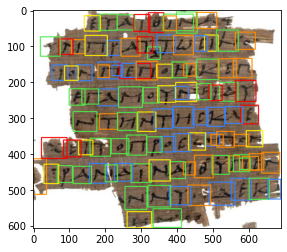

In [83]:
saveLinesImg(corlines, df)

In [172]:
def saveLinesImg(df, ll):
    tog = 0
    thickness = 3
    colorspace = [(55, 131, 255), (77, 233, 76), (255, 140, 0), (255, 238, 0), (246, 0, 0)]
    img = cv2.imread("static/data/current.jpg")[..., ::-1]
    image = img.copy()
    plt.figure()
    i = 1
    for i in range(ll):
        df2 = df[df['line'] == i]
        df2 = df2.reset_index()
        #print(df2)
        #print("******************************", len(df2))
        for j in range(len(df2)):
            # top left
            start_point = (int(df2['xc'][j] - (df2['width'][j] / 2)), int(df2['yc'][j] - (df2['height'][j] / 2)))
            # bttm right 
            end_point = (int(df2['xc'][j] + (df2['width'][j] / 2)), int(df2['yc'][j] + (df2['height'][j] / 2)))
            image = cv2.rectangle(image, start_point, end_point, colorspace[tog], thickness)
        tog += 1
        if tog >= len(colorspace):
            tog = 0
    plt.imshow(image)
    plt.savefig("static/data/yololocs.png")
    #plt.show()

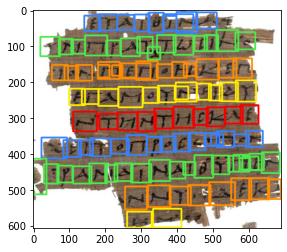

In [173]:
saveLinesImg(df, ll)